In [1]:
from duckduckgo_search import ddg_images
from fastdownload import download_url
from fastai.vision.all import Image, PILImage
from pathlib import Path
from fastai.vision.all import *
from fastcore.all import *
from time import sleep

In [2]:
def search_images(term, max_images=30):
    """
    Searches duckduckgo for images of a given term and returns a list of urls
    """
    print(f"Searching for '{term}...'")
    return [item["image"] for item in ddg_images(term, max_results=max_images)]

In [3]:
def generate_labelled_dataset(search_terms: list, path: Path, max_images: int = 10):
    """
    Simple wrapper around search_images and download_images
    """
    for search_term in search_terms:
        dest = path / search_term
        dest.mkdir(exist_ok=True, parents=True)
        download_images(dest, urls=search_images(f"{search_term} rhino photo"))
        sleep(0.5)  # Pause between searches to avoid over-loading server
        resize_images(path / search_term, max_size=400, dest=path / search_term)

In [4]:
def verify(path: str) -> None:
    """
    Verify that the images in the given path are valid.
    Note: Functional programming approach (new to me)
    """
    failed = verify_images(get_image_files(path))
    failed.map(Path.unlink)
    print(f"Removed {len(failed)} images that failed to open")

#### Train the Resnet Model

In [5]:
def learn(dls, save: bool = True):
    """
    Returns the pre-trained resnet34 fine-tuned on the given dataset
    """
    model = vision_learner(dls, resnet34, metrics=error_rate)
    model.fine_tune(3)
    if save:
        from datetime import datetime
        current_ds = datetime.now().strftime("%Y-%m-%d")
        model.export(Path.cwd() / f"models/fine_tuned_resnet34_{current_ds}.pkl")
    print(f"Finished fine-tuning. Error rate: {model.validate()}")
    return model


In [6]:
def get_dls(path, bs=64, size=192):
    """
    Returns a DataLoaders object for the given path
    """
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label,
        item_tfms=[Resize(size, method="squish")],
    )
    
def attach_dataloader(dls, path, bs):
    """
    Attaches a dataloader to the given DataLoaders object
    """
    return dls.dataloaders(path, bs=bs)

In [7]:
def predict(model: object, search_term: str):
    """
    Predicts the label of the given image
    Returns the label and the probability of that label
    """
    dest = f"jpgs/{search_term}s.jpg"
    urls = search_images(f"{search_term} photos", max_images=1)
    download_url(urls[0], dest, show_progress=False)
    print(f"Downloaded {urls[0]} to {dest}.")
    img = PILImage.create(dest)
    name, _, probs = model.predict(img)
    print(f"This is a: {name}.")
    print(f"Probability it's a {name}: {probs[0]:.4f}")
    return name, probs
    

Generating the labelled rhino dataset...

In [8]:
search_terms = ['black', 'white', 'sumatran', 'javan']
path = Path.cwd() / "rhinos"
# generate_labelled_dataset(search_terms, path, max_images=30)
verify(path)

Removed 0 images that failed to open


Generating the rhino DLS...

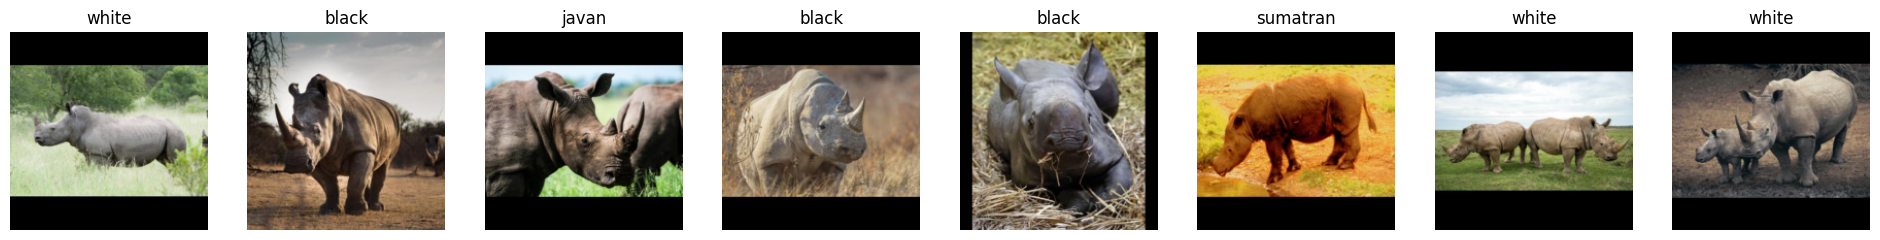

In [9]:
rhino_data_block = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label,
        item_tfms=[
                Resize(192, ResizeMethod.Pad, pad_mode='zeros')
                ]
        )
rhino_dls = rhino_data_block.dataloaders(path, bs=64)
rhino_dls.valid.show_batch(max_n=8, nrows=1)


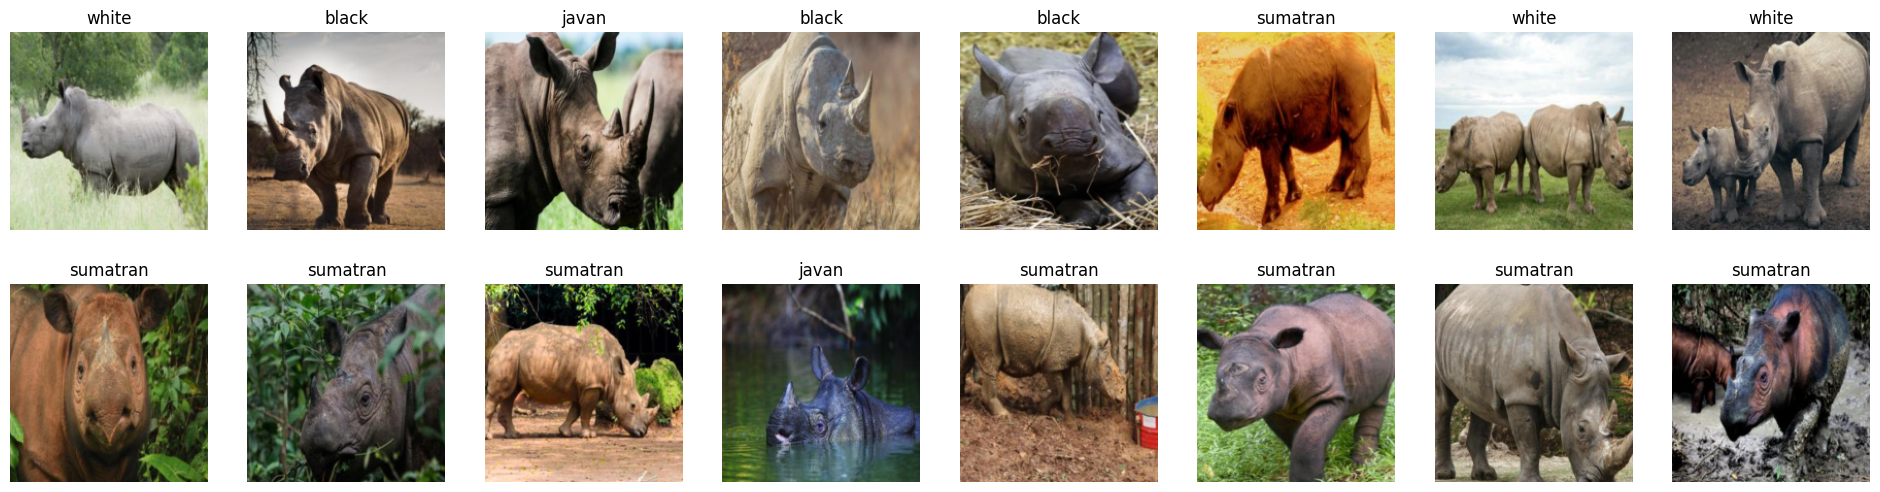

In [10]:
rhino_data_block = rhino_data_block.new(item_tfms=RandomResizedCrop(192, min_scale=0.1))
rhino_dls = rhino_data_block.dataloaders(path, bs=64)
rhino_dls.valid.show_batch(max_n=16, nrows=2)

In [11]:
model = vision_learner(rhino_dls, resnet34, metrics=error_rate)

/Users/hamzaalfadel/Desktop/Personal/code/ai-playground/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hamzaalfadel/Desktop/Personal/code/ai-playground/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
model.fine_tune(4)

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(model):
    """
    Returns the precision, recall and f1 score of the model on the given dataset
    """
    preds, targs = model.get_preds()
    preds = preds.argmax(dim=1)
    
    precision = precision_score(targs, preds, average='weighted')
    recall = recall_score(targs, preds, average='weighted')
    f1 = f1_score(targs, preds, average='weighted')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

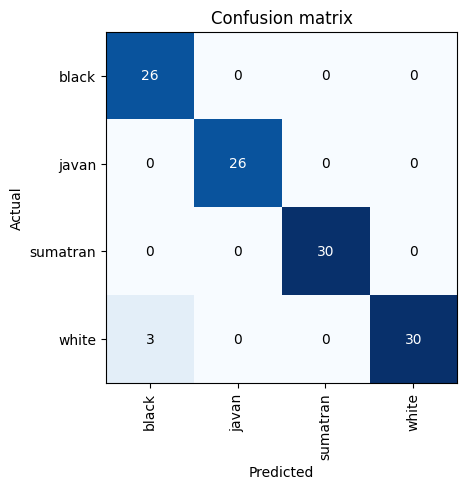

In [16]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix()

In [22]:
model.export(Path.cwd() / "models/fine_tuned_resnet34.pkl")

In [37]:
learn_inf = load_learner(Path.cwd() / "models/fine_tuned_rhino_resnet34.pkl")
pred_class, pred_idx, pred_probs = learn_inf.predict(Path.cwd() / "jpgs" / "sumatran.jpg")

class_names = learn_inf.dls.vocab
class_probs = list(zip(class_names, pred_probs))

# Format the result as a readable string
result_str = f"Predicted class: {pred_class}\n"
result_str += "\n".join([f"{class_name}: {prob:.4f}" for class_name, prob in class_probs])

# Print the result
print(result_str)

Predicted class: sumatran
black: 0.0441
javan: 0.0033
sumatran: 0.9526
white: 0.0000
